<h3>Multi-scale Topographic Classification using Support Vector Machines  - Atlantic Coastal Plain Prototype<h3>

In this notebook we experiment with using binary supervised classifier as a means to differentiate and map topographic landscapes. In particular, for this preliminary work, we attempt to model the U.S. Mid-Atlantic Coastal Plain, distinguishing it from its upland piedmont counterpart. The binary classifier selected is the support vector machine (SVM). SVMs are robust, high-dimensional, non-linear classifiers. The question is, are they sufficiently robust, and sensitive, to be able to reliably and consistently identify the boundary betweeen the upland piedmont and coastal plain provinces, a boundary that is subtle at best, even to the human eye? 

The overarching assumption here is that the coastal plain province, and by extension coastal plains in general, present topographic characteristics that differ geomorphically/geomorphometrically with the adjacent upland. Further, these differientiating characteristics can measured and used to build  classification model that distinguishes in some meaningful way, present a less topographically varied (i.e. rough) character than do the interior uplands [onto which the coastal plains abutt). Further, we assume that, in the presence of true assumptions, we can further identify, quantitatively model, and go on to map this difference and the two provinces--reliably. Repeatably. Maybe even globally!


<h3>The data:</h3>
0. The raw data from which the standard deviation products that follow are generated is a the GTOPO30 topographic digital elevation model from NOAA.

1. Fall-line data for NY, PA, MD, DE, and VA from USGS: https://pubs.usgs.gov/of/2005/1325/

2. Fall-line data for AL, MS, FL, GA, SC, NC from: https://pubs.usgs.gov/of/2005/1323/


We won't use AL and MS in this preliminary work, but they could prove useful later.


**Fall-line [source] projection params. for NY, PA, DE, MD, VA, FL, GA, SC, and NC**:<br />
Projection: Lambert Conformal Conic<br />
Horizontal datum: NAD 27<br />
Spheroid: Clarke, 1866<br />
Standard parallels: 33 degrees North  45 degrees North<br />
Central meridian: -100 degrees<br />
Reference Latitude: 0 degrees<br />
Horizontal units: meters<br />
False easting: 0<br />
False northing: 0<br />


<h3>The derivative data products:</h3>

<h4>1. Preparing the DEM from the GTOPO30 data:</h4>
**join or merge two GeoTif DEMs:** (http://www.gdal.org/gdal_merge.html)
gdal_merge.py -ot Float32 -o /Users/paulp/Downloads/dems/gt30w100n4090.tif -of GTiff /Users/paulp/Downloads/dems/gt30w100n90.dem /Users/paulp/Downloads/dems/gt30w100n40.dem

**to clip DEM to area of interest...** (http://www.gdal.org/gdal_translate.html) 
gdal_translate -of GTiff -ot Float32 -projwin -87.2164062867 43.5271520921 -66.45458687 27.7174503169  -co COMPRESS=DEFLATE -co PREDICTOR=1 -co ZLEVEL=6 /Users/paulp/Downloads/dems/gt30w100n4090.tif /Users/paulp/Downloads/dems/us_atlantic.tif

**project the clipped GeoTif, which is currently stored in unprojected GCS, to a regional Lambert Conformal Conic...** (http://www.gdal.org/gdalwarp.html)
gdalwarp -s_srs EPSG:4326  -t_srs '+proj=lcc +lat_1=33.0  +lat_2=40.0  +lat_0=36.5 +lon_0=-77.0  +x_0=0 +y_0=0 +a=6378160 +b=6356775 +units=m +no_defs' /Users/paulp/Downloads/dems/us_atlantic.tif /Users/paulp/Downloads/dems/us_atlantic_LCC.tif

**Lambert Conformal Conic projection info:**
+proj=lcc +lat_1=33.0  +lat_2=40.0  +lat_0=36.5 +lon_0=-77.0  +x_0=0 +y_0=0 +a=6378160 +b=6356775 +units=m +no_defs

**GTOPO30 data resolution 30 arc secs or about 1 km**



<h4>2. Preparing the vector shoreline from the World Vector Shoreline data</h4>
**Create a 'clip-box' polygon in QGIS to extract a shoreline geography that matches the extent of the DEM...**<br />
-87.2164062867 43.5271520921 -66.45458687 27.7174503169
and clip out that section of the WVS
Project the resulting shoreline section into the custom LCC for the prototype

**Load the DEM and shoreline into GRASS** (v.in.ogr) <br />
**Set a mask using the shoreline polygon** (r.mask)



<h4>3. Generating the random sample observation set:</h4>
**generate a set of 7000 random points across the field **<br />
r.random input=us_atlantic_elev_LCC npoints=7000 vector=u3krandompts

**add the columns: x, y, z, slope, and distance to the new random points layer FAT:**<br />
v.db.addcolumn map=u3krandompts columns='x double precision, y double precision, z double precision, slope double precision, distance double precision'

**add x and y coordinates of each sample point to the points data FAT:**<br />
v.to.db map= u3krandompts type=point option=coor columns=x,y

**add slope values to sample points FAT:**<br />
v.what.rast map=u3krandompts raster=us_atlantic_slope_LCC@user column=slope

**conflate value column contents to z:**<br />
v.db.update map=u3krandompts layer=1 column=z query_column=value

**drop column value as it is now redundant with the newly added, and more descriptive, z:**<br />
db.dropcolumn -f table=u3krandompts column=value

**compute the distance from each sample point to the nearest shoreline segment:**<br />
v.distance from=us3krandompts from_type=point to=US_Atl_Shoreline_LCC upload=dist column=distance


**and then, continue on in Jupyter...**

**Load Requisite Modules, Libraries, and Magics:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.neighbors import KernelDensity
#from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.kde import KDEUnivariate

sns.set()
%matplotlib inline

#%load_ext rpy2.ipython

**Load the [pre-labeled] sample observation data from GRASS**

NOTE: the pre-labeled data has not yet been assigned a class label (1 for coastal plain and -1 for not coastal plain). This will be done after some prelim. explorations.

In [ ]:
### Load the Data from the GRASS (SQLITE3) database:

### to read the GRASS attribute table: u3krandompts into pandas (Note that there are actually
### 7,000 points in the file...)
datapath='/Users/paulp/GoogleDrive/projects/GRASSData/USAtl_CoastalPlain_Prototype_LCC/user/sqlite/'
fn='sqlite.db' 

conn=sqlite3.connect(datapath+fn)   # create a connection to the database file:

# with the first load and subsequent plot (scatters in next cell) we discovered that there was
# an errant value with a z value of approx. -10,000 meters!. Since the data comes to us from 
# the GTOPO30 dataset, we know that there should be no elevation < 0 meters, so we adjust the
# sSQL select statement to weed this outlier from our data before we proceed...
df = pd.read_sql_query('select * from u3krandompts where z > 0.0', conn)

#df

**Topographic Elevation:  Simple Scatter Plots - All Data**

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.z, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Elevation (meters)')

ax2.scatter(df.y, df.z, s=5.0)
ax2.set_xlabel('y (meters)')



Plots of the entire 7000 point sample set. On the left is a plot of elevation across the x-axis of the LCC coordinate system; on the right are  the same elevations along the y-axis. Neither cloud is particularly revealing, though the narrow horizontal point bands see across the bottom of both plots does suggest a topographic signal dominated  by the low, gently sloping coastal plain: in the right siade plot the low "platform" on the left perhaps representing the low lands across S. Georgia and Northern and Central Florida. As we move to the right on that same plot we see the conuation of the coastal plain (as the low elevation horizontal band in the foreground) and the rise of the Appalachian Mountains from south northward.

**Topographic Slope:  Simple Scatter Plots - All Data**

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.slope, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Slope (degrees)')

ax2.scatter(df.y, df.slope, s=5.0)
ax2.set_xlabel('y (meters)')


Plot of topographic slope (computed as first derivative of elevation) along the projection x-axis (left plot) and y-axis (right plot). Two things to glean here: first, the distribution of slopes across the entire area rarely exceeds 10 degrees, and second, in the right plot we see the relatively "very" flat areas in the south (Florida and S. Georgia) grading into the more varied sloped Appalachians as we more from south to north (left to right). The coastal plain (our geomorphic feature of interest) is easily seen in the south. Northward, the backgound mountain slopes mask (to some degree) the gentle foreground of the coastal plain. Still, there is a coastal plain seen in these plots. Question is: can we discriminate between slopes (and elevations, too) between that coastal plain and elsewhere? 

**Topographic Elevation:  Simple Scatter Plots - Slopes <=0.69 degrees**

Based on Paris, Walsh, and Corbett, 2016, we can extend the constraint placed on continental shelf slopes to its subaerial component, the coastal plain, by subsetting the original 7000 point sample set into a subgroup containing only those points where the topographic slope is <= 0.69 degrees. 

In [ ]:
# Extract a new dataframe from the query results where slopes are <= 0.69 degrees:
df2=df.query('slope <= 0.69')
df2.describe()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df2.x, df2.z, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Elevation (meters)')

ax2.scatter(df2.y, df2.z, s=5.0)
ax2.set_xlabel('y (meters)')

**Topographic Slope:  Simple Scatter Plots - Slopes <=0.69 degrees**

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax1.scatter(df2.x, df2.slope, s=5.0)
ax1.set_xlabel('x (meters)')
ax1.set_ylabel('Slope (degrees)')

ax2.scatter(df2.y, df2.slope, s=5.0)
ax2.set_xlabel('y (meters)')

I envision that the thin horizontal bands that are seen across the bottom of both plots is tied, in large measure, to coastal plain topography in the foreground. The mass of points raining down from the top of the plots are representative of both the greater absolute slopes and variation in slope seen across the uplands and background mountain ranges.

**Elevation vs.Slope:**

In [ ]:
plt.scatter(df2.slope, df2.z, s=5.0)
plt.ylabel('elevation (meters)')
plt.xlabel('slope (degrees)')

Two horizontal bands are seen across the plot's bottom. Could it be a reasonable assumption that the band from z=0 to about 125 to 150 m represent a 'coastal plain'? If so, or for whatever it truly represents, can we detect it?

**Slope vs Distance from Shore:**

In [ ]:
plt.scatter(df2.distance, df2.slope, s=5.0)
plt.xlabel('sample point distance from coast (meters)')
plt.ylabel('slope (degrees)')

Hmm...

**Elevation vs Sample Point Distance from Shore:**

In [ ]:
### Plot of Distance from sampling point to shore and elevation:
plt.scatter(df2.distance, df2.z, s=5.0)
plt.xlabel('sample point distance from coast (meters)')
plt.ylabel('elevation above MSL (meters)')

**Clustering and Density Estimation using the Gaussian Mixture Model**

While I don't place much confidence in an unclassifed scheme being sufficiently robust to be able to parse the data distributions see in the previous plots, it might be able to do enough to give us a hint as to how well a more robust supervised classifier (SVM in this case) might perform.  To find out we'll appeal to a Gaussian Mixture Model (GMM)...

**GMMs applied to the entire 7000 observation dataset:**

In [ ]:
### Experiments on the ENTIRE dataframe:

from sklearn.mixture import GaussianMixture
gmx=GaussianMixture(n_components=2, covariance_type='full')

X=df[['z','slope']]  #[:,np.newaxis]

gmx.fit(X)
y=gmx.predict(X)
df['cluster']=y

fg=sns.FacetGrid(data=df, size=7, hue='cluster', aspect=0.85)
fg.map(plt.scatter, 'x', 'y', s=5)

In [ ]:
fg=sns.FacetGrid(data=df, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'distance', 'slope', s=5)

**GMMs applied to a subset of the 7000 observation dataset where slope <= 0.69 degrees:**

In [ ]:
### Experiments on the SLOPES <= 0.69 dataframe (df2):

from sklearn.mixture import GaussianMixture
gmx=GaussianMixture(n_components=2, covariance_type='full')

X=df2['z'][:,np.newaxis]
gmx.fit(X)
df2['cluster']=gmx.predict(X)

fg=sns.FacetGrid(data=df2, size=7, hue='cluster', aspect=0.85)
fg.map(plt.scatter, 'x', 'y', s=5)

In [ ]:
fg=sns.FacetGrid(data=df2, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'x', 'z', s=5)
plt.legend(loc='best')

**Kernel Density Estimates**

- **Elevation:**

In [ ]:
kde = KDEUnivariate(df2.z)
kde.fit(bw=10.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df2.z, bins=25, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');
#ax.set_xlim(0,100)
#ax.plot(kde.support, kde.cdf)

The distribution of elevations is distinctly bi-model (with some suggestion of tri-modality, but we ignore this, chalking it up to an artifact associated with the present selection of bins and bandwidth). Most of the elevations are concentrated in the second mode, but it is perhaps in the first peak that we might assume our coastal plain exists. Maybe...

What about the distribution of slopes...

- **For Slope:**

In [ ]:
kde = KDEUnivariate(df2.slope)
kde.fit(bw=0.03)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df2.slope, bins=10, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');

Here we find that most of the slopes are concentrated in a range between about 0.3 degrees and flatness. Otherwise, the plot doesn't immediately give us much help in isolating the coastal plain province from everything else. 

The final metric, distance from the shore, would be expected to reveal little in a KDE for it's bult from a set of randomly distributed sample points spread across the study region. That we've subset the data based on our slope criteria (slope <= 0.69 degrees) does, however, offer up the possibility that something might be revealed in the distribution of the remaining points. Let's see...

- **For distance from the Shoreline:**

In [ ]:
kde = KDEUnivariate(df2.distance)
kde.fit(bw=7500.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df2.distance, bins=10, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');

There's a whole bunch of variance in the data (note the irregular KDE, and this with a bandwidth of 7500!) but it would appear that we can see a large number of sample points siting in close proximity to the coast--as we expected, right? 

It might be possible that a well-executed unsupervised classifier can separate the observations that occur less than about 300,000 meters (~300 km or ~180 statute miles) from the coast. Note that these are aggregate numbers. They do not everywhere, perhaps even anywhere, reflect the actual width of the coastal plain. Honestly though, I doubt it would present a clean, definitive, convincing partitioning of the data---the world is simply too complicated.

<h3>Applying the Support Vector Machine</h3>

A new dataset, one based on the originals found above in dataframes df and df2, was generated which replaced the 'cluster' with the attribute 'label'. The label attribute was populated so as to convert the original sample points in to one suitable to serve as a training and testing data set for the coming SVM experiments.  

Label is populated as either = 1 (is classified as falling inside the coastal plain) or -1 (is classified as NOT falling in the coastal plain). These assignments were conducted in QGIS using geologic data downloaded from the USGS which permitted mapping a 'fall-line' that would delineate the upland boundary of the U.S. Altantic Coastal Plain.

Let's proceed...

**Load the new sample data set and partition into a predictor X matrix and y response array...**

In [5]:
### LOADER CELL

import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

datapath='/Users/paulp/GoogleDrive/projects/CoastalPlains/data/'
file='CoastalPlainTrainingPts.csv'

### load the training points to a pandas dataframe, then extract a random
### sample subset for testing. The entire 7k set will demaind a lot of
### computer resources so it would be best to get things checked out on
### a smaller, less computationally demanding sample set...
dfsvm=pd.read_csv(datapath+file)
dfsvm2k = dfsvm.sample(n=100, replace=False)

X=np.array(dfsvm2k[['z','distance']])   #,'distance'
y=np.array(dfsvm2k['label']) 
print(np.shape(y), np.shape(X))

(100,) (100, 2)


In [ ]:
# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

First, we'll plot the observation sample, labeling the points based on their respective designations as either falling in the coastal plain or not (the y array) to see if the data might be linearly seperable. Note that is highly unlikely, but it's always a good idea to have a look at the data. Note too that since we are extracting a random subsample from the full data set (at least for now) the point pattern seen in the plot will vary a little, or a lot, with each run of the loader cell, above...

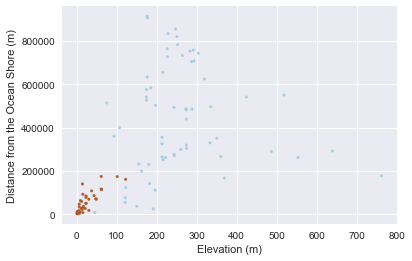

In [6]:
plt.scatter(X[:,0],X[:,1], c=y, s=7, cmap=mpl.cm.Paired)
plt.xlabel('Elevation (m)')
plt.ylabel('Distance from the Ocean Shore (m)')

There is nothing here in the plot to suggest that a linear partition will cleanly and completely separate the coastal plain (tan-colored dots) from the upland (blue-colored dots). Still, we can see that the coastal plain group (y = 1) are, as would be expected, clustered in the plot's lower-left corner. Further, there is incomplete overlap between coastal plain and upland observations (blue dots). This suggests that, while a nice, neat linear, error free classifier isn't in the cards, a useful SVM model that can partition the two regions may well be possible.

Let's do some experiments to see if we can fit just such a reasonable Support Vector Machines model...

In [ ]:
parameters=[{'kernel':['linear'], 'C':[0.1, 1, 5, 10, 100]}]
sv=svm.SVC()
clf = GridSearchCV(estimator=sv, param_grid=parameters, cv=10)
clf.fit(X,y)

find a 'fall-line' layer, or digitize one, if necessary, and then:
    
- sample elevations along the line
- plot these elevations against the distance to shore / elevation plot, seen above

Q: What is a coast? How can we define it geomorphically? Geomorphometrically?

**Prelim. Title:** Defining the Geomorphometric Coastal Plain: A Machine Learning Approach

What characteristics are important and which of these can be used to define the a 'the coast' as a unique geomorphic entity? 

Elevations
Slopes

If the U.S. East Coast can be considered an archetype, (for model training), can we use it to identify 'coasts' or 'coastal plains' elsewhere in the world? Dunno.